In [1]:
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.datasets import mnist
from keras.models import Model
import keras

from keras.datasets import cifar10
import skimage
import numpy as np
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
types = ["dogs", "cats"]
images = []
labels = []
for type in types:
    filenames = glob.glob("./dataset/training_set/" + type + "/*", recursive=True)
    for filename in tqdm(filenames):
        image = skimage.io.imread(filename)
        image = skimage.transform.resize(image, (224, 224, 3)).astype(np.float32)
        images.append(image)
        if type == "dogs":
            label = 0
        else:
            label = 1
        labels.append(label)



Using TensorFlow backend.
  0%|          | 0/4000 [00:00<?, ?it/s]/home/sunyue/.pyenv/versions/3.6.6/envs/nsfw/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/sunyue/.pyenv/versions/3.6.6/envs/nsfw/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:36<00:00, 109.15it/s]


In [7]:
images = np.array(images)
labels = np.array(labels)
y_train = labels
x_train = images
y_train = keras.utils.to_categorical(y_train,2)

In [4]:
from keras.optimizers import Adam, SGD, RMSprop


model = keras.applications.resnet50.ResNet50()
model.layers.pop()
last = model.layers[-1].output
x = Dense(2, activation="softmax")(last)
finetuned_model = Model(model.input, x)
finetuned_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
finetuned_model.summary()
finetuned_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, 
                callbacks=None, validation_split=0.1, shuffle=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Train on 7200 samples, validate on 800 samples
Epoch 1/10
7200/7200 [==============================] - 69s 10ms/step - loss: 0.0903 - acc: 0.9665 - val_loss: 0.1089 - val_acc: 0.9587
Epoch 2/10
7200/7200 [==============================] - 58s 8ms/step - loss: 0.0232 - acc: 0.9933 - val_loss: 0.0277 - val_acc: 0.9850
Epoch 3/10
7200/7200 [==============================] - 58s 8ms/step - loss: 0.0177 - acc: 0.9946 - val_loss: 0.0581 - val_acc: 0.9788
Epoch 4/10
7200/7200 [==============================] - 58s 8ms/step - loss: 0.0084 - acc: 0.9978 - val_loss: 0.1121 - val_acc: 0.9625
Epoch 5/10
7200/7200 [==============================] - 58s 8ms/step - loss: 0.0097 - acc: 0.9967 - val_loss: 0.0380 - val_acc: 0.9888
Epoch 6/10
7200/7200 [==============================] - 58s 8ms/step - loss: 0.0078 - acc: 0.9979 - val_loss: 0.0346 - val_acc: 0.9912
Epoch 7/10
7200/7200 [==============================] - 58s 8ms/step - loss: 0.0134 - acc: 0.9950 - val_loss: 0.0849 - val_acc: 0.9775
Epoch 8

In [ ]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
model =finetuned_model
class_weights = model.layers[-1].get_weights()[0]
final_conv_layer = model.layers[-3]
cam_model = Model(model.layers[0].input, [model.layers[-3].output, model.layers[-1].output])
cam_model.save("test.h5")

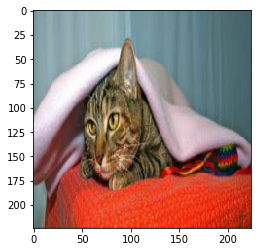

predictions [[1.4409571e-10 1.0000000e+00]]


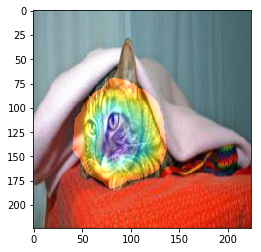

In [25]:
from keras.models import load_model
cam_model = load_model("test.h5")
idx = 7000
plt.imshow(x_train[idx, :, :, :])
plt.show()
img = x_train[idx][None, :, :, :]
original_img = x_train[idx][None, :, :, :]
[features, predictions] = cam_model.predict([img])
class_weights = cam_model.layers[-1].get_weights()[0]
features = features[0, :, :, :]
cam = np.dot(features, class_weights[:, 1])
print( "predictions", predictions)
cam /= np.max(cam)
cam = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.2)] = 0
img = original_img
img = (img*255).astype(np.uint8)
img = img + heatmap*0.5
cv2.imwrite("example.png", img[0])
plt.imshow(cv2.imread("example.png"))
plt.show()